## the code we wrote for creating the data.
## https://github.com/anryabrahamyan/Road_Traffic_Prediction/

# The following file is the second approach which is averaging our observations for each hour.

In [9]:
!pip install matplotlib
!pip install statsmodels
!pip install pmdarima

     |████████████████████████████████| 9.9 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 99.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 24.7 MB/s eta 0:00:01


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import pmdarima as pm
import numpy as np
from datetime import timedelta 

## Loading and preprocessing the data

In [12]:
df = pd.read_csv("../dataset/data.csv")
df.datetime = pd.to_datetime(df.datetime,format = "%d/%m/%Y %H:%M:%S")
df.index = df.datetime
df.drop(columns = ['datetime'], inplace = True)
df.head()

,weather_main,weather_desc,temp,feels_like,temp_min,temp_max,pressure,humidity,visibility,wind_speed,...,Motorcycle_0.9,Motorcycle_0.7,Motorcycle_0.5,Motorcycle_0.3,Motorcycle_0.1,Ambulance_0.9,Ambulance_0.7,Ambulance_0.5,Ambulance_0.3,Ambulance_0.1
datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-10 20:44:39,Clouds,broken clouds,8.60,3.60,7.31,10.04,1008,47,10000,13.89,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:49:39,Clouds,broken clouds,8.60,3.60,7.31,10.04,1008,47,10000,13.89,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:54:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:59:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 21:04:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0


In [13]:
for col in ['weather_main','weather_desc']:
    data = pd.get_dummies(df[col])
    df = pd.concat([df,data],axis = 1)
    df.drop(columns = [col],inplace=True)

In [14]:
#fix weird time period
df = df.replace("None", np.nan) 
df.loc[72:144,'Vehicle_0.1'] = np.nan

/tmp/ipykernel_118/3596543675.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[72:144,'Vehicle_0.1'] = np.nan


In [15]:
for col in df.columns:
    df[col] = df[col].astype('float64')

In [16]:
#convert the index to date/time and remove the ones with missing vehicle data
df_cleaned =pd.DataFrame( index=pd.date_range(df.index.min(),df.index.max(),freq='min'))
df_cleaned.index = df_cleaned.index.round(freq='min')
df.index = df.index.round(freq='min')
df_without_na = df[~df['Vehicle_0.1'].isna()]

In [17]:
#add the data to the cleaned dataframe
columns = df.columns.values
for column in columns:
    df_cleaned[column] = np.nan
df_cleaned.loc[df_without_na.index,columns]=df_without_na[columns]

In [20]:
#iteratively fill with the rolling mean
rolling_mean_30 = df_cleaned.copy()
while sum(rolling_mean_30.isna().sum().values)>0:
    rolling_mean_30.fillna(rolling_mean_30.rolling(30, min_periods=1).mean().shift(),inplace=True)
df_cleaned=rolling_mean_30

<AxesSubplot:>

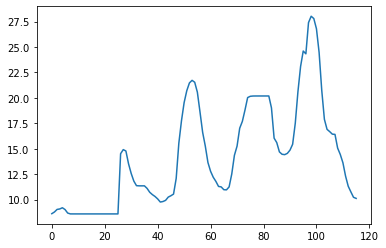

In [21]:
# compute the means for the filled data
df_cleaned['Vehicle_0.1'] = df_cleaned['Vehicle_0.1'].astype(int)
df_cleaned = df_cleaned.groupby([df_cleaned.index.day,df_cleaned.index.hour]).mean().reset_index()
df_cleaned.rename({'level_0':'day','hour':'hour'},inplace=True)
df_cleaned['temp'].plot()

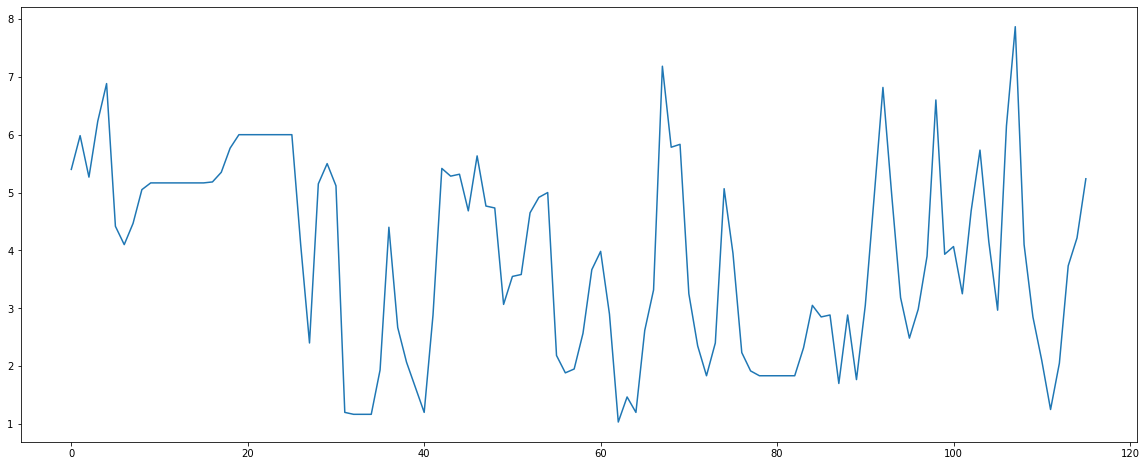

In [22]:
plt.figure(figsize=(20,8))
plt.plot(df_cleaned["Vehicle_0.1"].astype(float))
plt.show()

In [23]:
df_cleaned

,level_0,level_1,temp,feels_like,temp_min,temp_max,pressure,humidity,visibility,wind_speed,...,clear sky,drizzle,few clouds,heavy intensity rain,light rain,moderate rain,overcast clouds,scattered clouds,squalls,thunderstorm
0,10,20,8.612444,3.828667,7.296000,10.054000,1008.000000,47.311111,10000.0,12.911556,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.155556,0.0,0.0,0.0
1,10,21,8.779033,4.738022,7.508622,10.122156,1008.000000,47.646667,10000.0,9.511233,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.906667,0.0,0.0,0.0
2,10,22,9.031611,5.459389,7.725444,10.277111,1008.000000,45.666667,10000.0,7.956667,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3,10,23,9.077056,5.133389,7.967667,10.224500,1007.250000,45.250000,10000.0,9.385000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
4,11,0,9.196278,5.222444,7.860778,10.307556,1007.583333,45.127778,10000.0,9.664444,...,0.000000,0.555556,0.0,0.0,0.0,0.0,0.444444,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,15,11,12.307500,10.752500,8.566667,14.382833,1017.000000,44.433333,10000.0,3.602500,...,0.750000,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0
112,15,12,11.313500,9.779000,7.365167,13.460667,1017.750000,49.000000,10000.0,3.046667,...,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
113,15,13,10.758000,9.237000,5.976000,12.848000,1018.333333,51.666667,10000.0,3.062500,...,0.750000,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0
114,15,14,10.225727,8.738108,5.264651,12.698990,1019.000000,54.800322,10000.0,3.585998,...,0.299919,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


From the plot we can see that there is no trend, however there is some seasonality because the frequency of the cars decreases after 12am.

In [92]:
X = df_cleaned["Vehicle_0.1"]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.480776
p-value: 0.120222
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581


We can see that p value of ADF statistics is almost 0 which is smaller than 0.05, thus we reject the null hypothesis and conclude that our series is stationary.

In [93]:
result = kpss(X)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('number of lags: %f' % result[2])

print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.343838
p-value: 0.100000
number of lags: 13.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


We have p-value equal to 0.1, which is larger than 0.05, thus we can say that we have stationary time series.

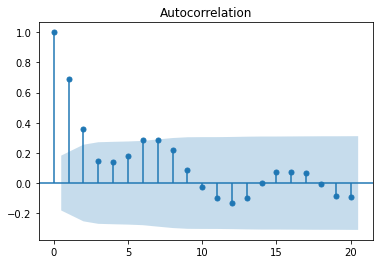

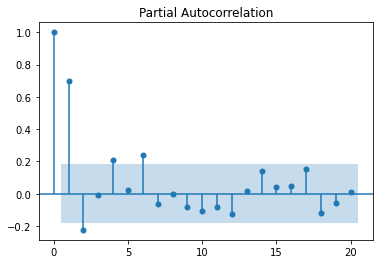

In [94]:
plot_acf(X, lags=20)     
plot_pacf(X, lags=20)     
plt.show()

From the ACF plot we can see that all lags are significant up to lag 3 for the MA process. In PACF we have significant lags until lag 2 and then cuts off, so we will choose lag as 2.

In [12]:
#X = pd.concat([X,X,X])
#X.reset_index(drop= True, inplace = True)

In [95]:
total_observations = len(X)
train = X[:int(0.8*total_observations)]
test = X[int(0.8*total_observations):]

In [96]:
model = ARIMA(train.astype(float),order=(2, 0, 3)).fit()

In [97]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            Vehicle_0.1   No. Observations:                   92
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -136.763
Date:                Wed, 11 May 2022   AIC                            287.525
Time:                        10:12:07   BIC                            305.178
Sample:                             0   HQIC                           294.650
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9232      0.511      7.677      0.000       2.922       4.925
ar.L1          0.8264      0.591      1.398      0.162      -0.333       1.985
ar.L2          0.0486      0.421      0.116      0.9

In [98]:
predictions = model.forecast(len(test))
residuals = test.astype(float) - predictions

Text(0, 0.5, 'Error')

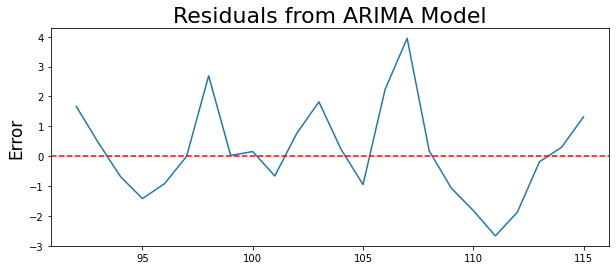

In [99]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals from ARIMA Model', fontsize=22)
plt.ylabel('Error', fontsize=17)

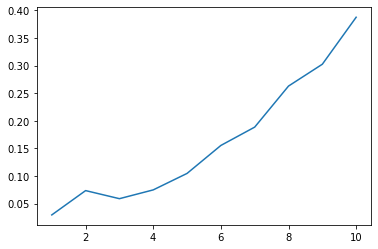

In [100]:
Lj_Box = sm.stats.acorr_ljungbox(residuals, lags = 10,return_df = True)
plt.plot(Lj_Box.index, Lj_Box.lb_pvalue)

The p-values are increasing with the lags, so the model does not capture some of the patterns in the data and the errors are correlated after lag 3(for p-crit = 0.05).

In [101]:
#WE do not consider the seasonal component because the order of dependence for 1 day is 1440 and it will take forever to fit that model. Further aggregations of the data will help with this problem.
model_auto=pm.auto_arima(
    train,
    test='adf',
    max_p = 12,
    max_d = 1,
    max_q = 12,
    seasonal=True,
    m=24,
    max_P=24,
    max_Q=24,
    max_D=1,
    trace=True,
    error_action='ignore', 
    suppress_warnings=True,
    stepwise=True,
    n_fits=120,
    maxiter=11,
    n_jobs=-1)

C:\ProgramData\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=285.331, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=293.506, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=293.656, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=292.735, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=291.507, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=283.761, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=287.577, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=285.754, Time=0.80 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=284.054, Time=0.30 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=287.475, Time=0.86 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=282.475, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=286.496, Time=0.08 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=284.955, Time=0.32 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=284.483, Time=0.67 sec
 ARIMA(1,1,2)(1,0,0)[24] intercep

In [102]:
print('MSE of the AUTOARIMA model is', np.mean((model_auto.predict(len(test))-test.astype("float"))**2))

MSE of the AUTOARIMA model is 6.255935429267377


In [103]:
print('MSE of the previously chosen model is', np.mean((model.forecast(len(test)) - test.astype("float")) **2))

MSE of the previously chosen model is 2.350160350024541


We can observe that the MSE of the previously chosen model is lower, meaning that it is better if we take into consideration MSEs. This procedure might be incorrect because autoarima minimized the AIC and not the MSE, but the autoarima also included the seasonality of 24 hours, so this is a sign that there is little information in knowing the same number of cars for the previous day.

In [104]:
model = ARIMA(train.astype(float),order=(2,0,3)).fit()
predictions = model.forecast(24)#24 hours

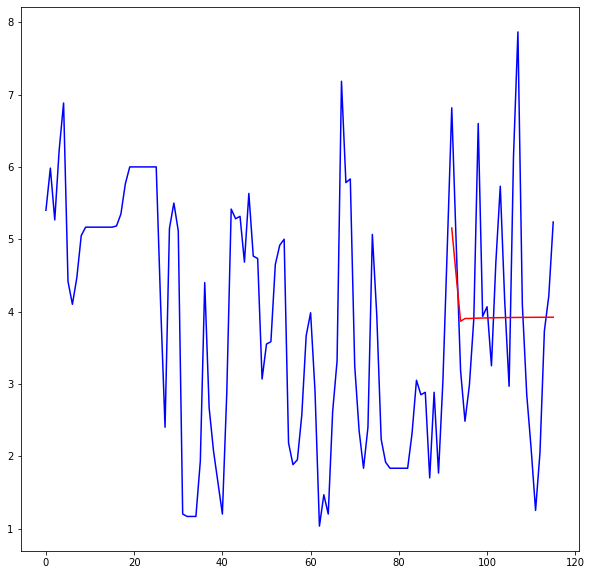

In [105]:
fig = plt.figure(figsize = (10,10))
plt.plot(X,'blue')
plt.plot(predictions,c='red')
plt.show()

In [106]:
exp_smooth = ExponentialSmoothing(train.astype(float),trend=None, seasonal = 'add',initialization_method='estimated',seasonal_periods=24).fit()

## Car traffic is generally stationary in terms of trend, and the seasonality is additive because the variance is not increasing over time.

In [107]:
predictions = exp_smooth.forecast(len(test))
print('MSE of the exp_smoothing model is', np.mean((predictions.values-test.astype("float"))**2))

MSE of the exp_smoothing model is 4.554008916290996


## The exponential smoothing model is worse than the Arima model from before.

In [108]:
exp_smooth = ExponentialSmoothing(train.astype(float),trend=None, seasonal = 'add',initialization_method='estimated',seasonal_periods=24).fit()

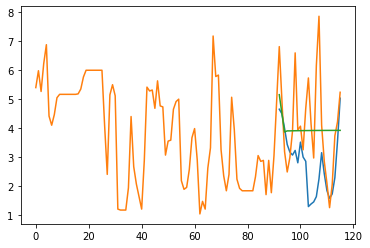

In [109]:
ax = plt.subplot()
ax.plot(exp_smooth.forecast(24))
ax.plot(X.astype(float))
ax.plot(model.forecast(24))
#ax.plot(predictions)

plt.show()

In [110]:
size = int(len(X) * 0.8)
train_new, test_new = list(X[0:size]), list(X[size:len(X)])

history = [x for x in train_new]
predictions = list()

In [111]:
# walk-forward validation
for t in range(len(test_new)):
    model_new = ARIMA(history, order=(2,0,3))
    model_fit = model_new.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_new[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=5.154806, expected=6.816667
predicted=6.003751, expected=4.950000
predicted=4.038232, expected=3.183333
predicted=2.947556, expected=2.483333
predicted=3.146416, expected=2.983333
predicted=3.380108, expected=3.900000
predicted=4.068294, expected=6.600000
predicted=6.342761, expected=3.933333
predicted=3.325790, expected=4.066667
predicted=3.559670, expected=3.250000
predicted=4.171214, expected=4.683333
predicted=4.182118, expected=5.733333
predicted=5.506548, expected=4.150000
predicted=3.783980, expected=2.966667
predicted=2.843532, expected=6.150000
predicted=6.318676, expected=7.866667
predicted=6.901330, expected=4.100000
predicted=3.060180, expected=2.850000
predicted=3.572459, expected=2.100000
predicted=3.139278, expected=1.250000
predicted=1.729521, expected=2.050000
predicted=3.271156, expected=3.733333
predicted=3.939827, expected=4.216667
predicted=3.855454, expected=5.238095


In [112]:
Rolling = train_new + predictions

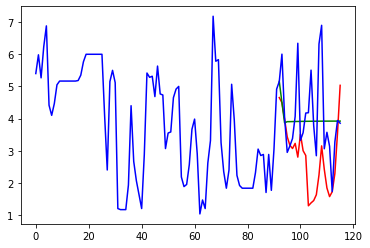

In [113]:
ax = plt.subplot()
ax.plot(exp_smooth.forecast(24),color = "red")
ax.plot(model.forecast(24),color = "green")
ax.plot(Rolling,color = "blue")

plt.show()